In [11]:
# imports
import wrangle
import f_engineer
import prepare
import pandas as pd
from scipy.stats import pearsonr, ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
import f_engineer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import  mean_squared_error, explained_variance_score



Acquire/Wrangle

In [12]:
# utilize wrangle.py to load data
df = wrangle.get_zillow_project_data()
df.head() # check the first 5 rows of the data

Let me get that for you...


,parcelid,bathroomcnt,bedroomcnt,finishedsquarefeet12,fips,lotsizesquarefeet,yearbuilt,taxvaluedollarcnt,logerror,transactiondate
0,12923725,2.0,3.0,1976.0,6037.0,9728.0,1955.0,403193.0,0.029309,2017-01-11
1,12746742,1.0,2.0,749.0,6037.0,5028.0,1950.0,153005.0,0.012232,2017-01-11
2,12461319,2.0,3.0,1470.0,6037.0,6336.0,1942.0,399808.0,0.019818,2017-01-11
3,12089426,1.0,3.0,1120.0,6037.0,5002.0,1923.0,67850.0,0.033812,2017-01-11
4,12678665,2.0,3.0,1175.0,6037.0,5531.0,1956.0,296847.0,-0.055222,2017-01-11


In [13]:
# prep the data for modeling and feature engineering
df = wrangle.zillow_proj_prep(df)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 51834 entries, 0 to 52441
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        51834 non-null  float64
 1   bedrooms         51834 non-null  float64
 2   sqft             51834 non-null  float64
 3   county_fips      51834 non-null  float64
 4   lotsqft          51834 non-null  float64
 5   year             51834 non-null  float64
 6   value            51834 non-null  float64
 7   logerror         51834 non-null  float64
 8   transactiondate  51834 non-null  object 
dtypes: float64(8), object(1)
memory usage: 4.0+ MB


In [14]:
# check data for nulls
df.isnull().sum()

bathrooms          0
bedrooms           0
sqft               0
county_fips        0
lotsqft            0
year               0
value              0
logerror           0
transactiondate    0
dtype: int64

In [15]:
df.head()

,bathrooms,bedrooms,sqft,county_fips,lotsqft,year,value,logerror,transactiondate
0,2.0,3.0,1976.0,6037.0,9728.0,1955.0,403193.0,0.029309,2017-01-11
1,1.0,2.0,749.0,6037.0,5028.0,1950.0,153005.0,0.012232,2017-01-11
2,2.0,3.0,1470.0,6037.0,6336.0,1942.0,399808.0,0.019818,2017-01-11
3,1.0,3.0,1120.0,6037.0,5002.0,1923.0,67850.0,0.033812,2017-01-11
4,2.0,3.0,1175.0,6037.0,5531.0,1956.0,296847.0,-0.055222,2017-01-11


In [16]:
# remove outliers
df = prepare.remove_outliers_fips(df, 1.5)

In [17]:
# split the dataframe into train, validate, and test
train, validate, test = wrangle.split_dataframe(df)
print(train.shape)
print(validate.shape)
print(test.shape)

(22979, 9)
(9849, 9)
(8208, 9)


EXPLORE

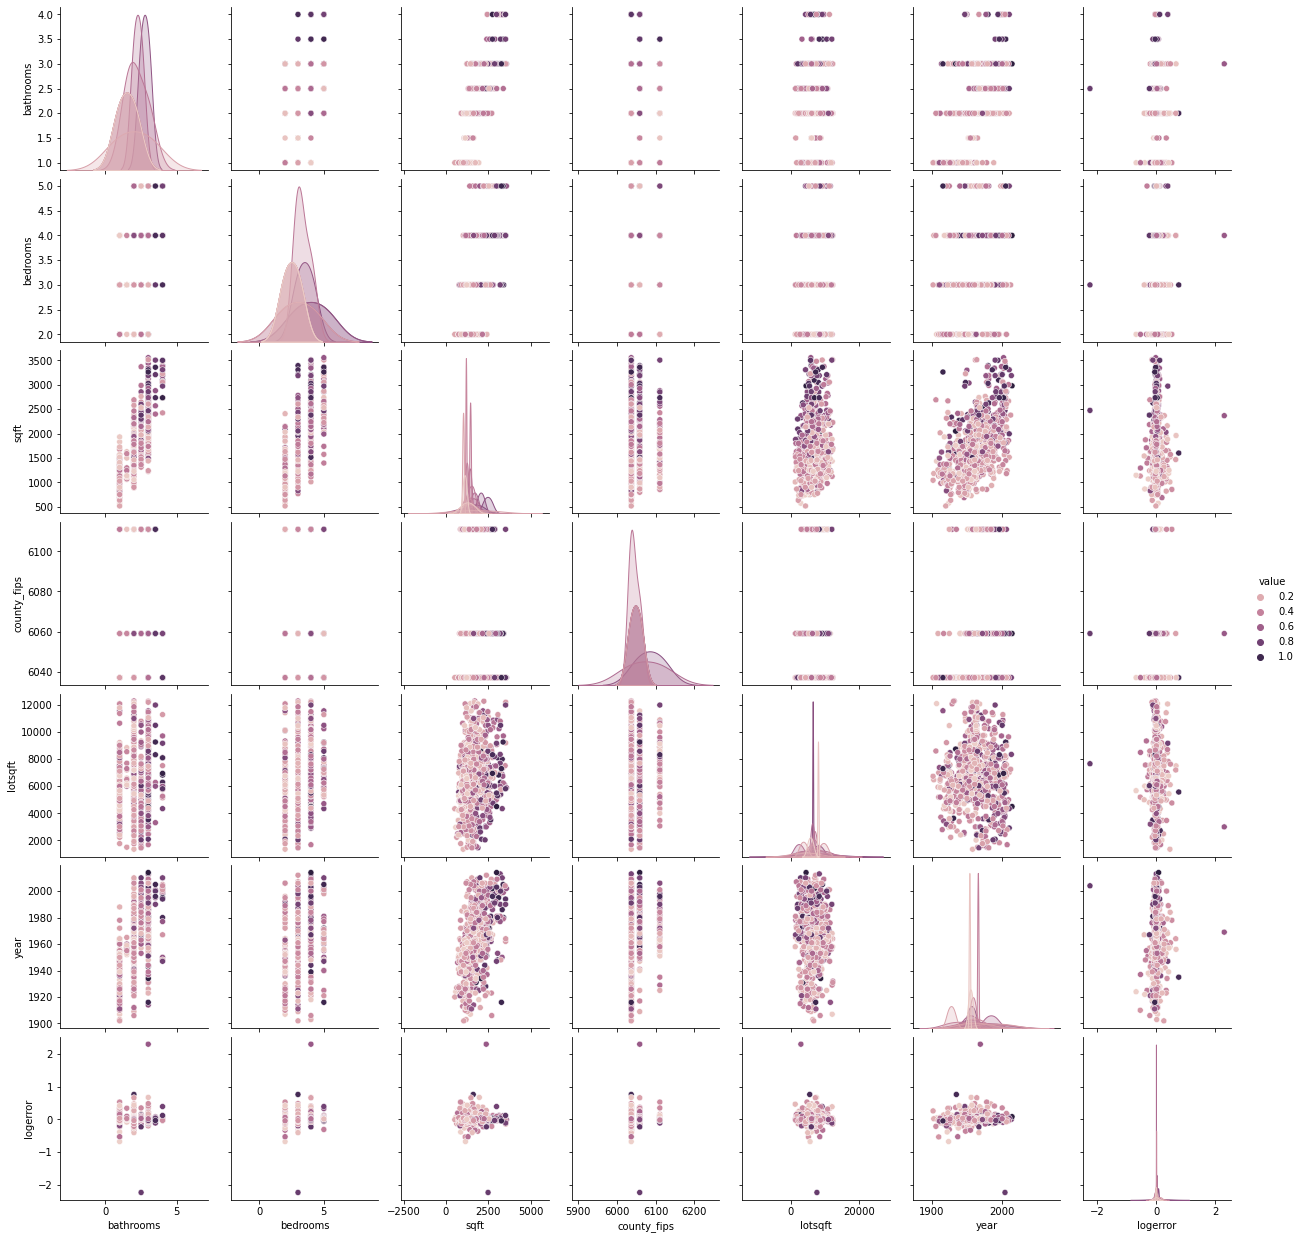

In [18]:
# create sample of train dataset for easier visualization
train_sample = train.sample(n=1000)
# create a pairplot of the sampled train dataset
sns.pairplot(train_sample, hue = 'value')

In [19]:
train_sample.corr()

,bathrooms,bedrooms,sqft,county_fips,lotsqft,year,value,logerror
bathrooms,1.000000,0.568146,0.778473,0.142155,0.120334,0.609217,0.348293,0.041497
bedrooms,0.568146,1.000000,0.629533,0.138791,0.189520,0.371824,0.194983,0.039746
sqft,0.778473,0.629533,1.000000,0.149752,0.195344,0.523556,0.417018,0.002064
county_fips,0.142155,0.138791,0.149752,1.000000,-0.025940,0.261648,0.126356,0.027361
lotsqft,0.120334,0.189520,0.195344,-0.025940,1.000000,-0.022453,-0.049237,-0.019544
year,0.609217,0.371824,0.523556,0.261648,-0.022453,1.000000,0.195797,0.024914
value,0.348293,0.194983,0.417018,0.126356,-0.049237,0.195797,1.000000,-0.030039
logerror,0.041497,0.039746,0.002064,0.027361,-0.019544,0.024914,-0.030039,1.000000


In [20]:
# correlation of all features vs. value]
train_sample.corr()['value'].sort_values(ascending=False)

value          1.000000
sqft           0.417018
bathrooms      0.348293
year           0.195797
bedrooms       0.194983
county_fips    0.126356
logerror      -0.030039
lotsqft       -0.049237
Name: value, dtype: float64

In [21]:
# Correlation tests are used to check if two features are correlated
# the closer the correlation is to 1, the more correlated the features are
# value and sqft pearsonr
r, p = pearsonr(train.value, train.sqft)
r,p

(0.4343069897826059, 0.0)

In [22]:
# value and bathrooms pearsonr
r, p = pearsonr(train.value, train.bathrooms)
r,p

(0.3575196368640503, 0.0)

In [23]:
# value and bathrooms pearsonr
r, p = pearsonr(train.value, train.bathrooms)
r,p

(0.3575196368640503, 0.0)

In [24]:
# value and lotsqft pearsonr
r, p = pearsonr(train.value, train.lotsqft)
r,p


(0.021593724548362916, 0.001062023357338435)

In [25]:
# value and area ttest_ind
f, p = ttest_ind(train.value, train.sqft)
f, p

(231.75984297442676, 0.0)

In [26]:
# t test are used to check if two features are statistically different
# the closer the p value is to 0, the more statistically significant the test
# value and bedrooms ttest_ind
f, p = ttest_ind(train.value, train.bedrooms)
f, p

(232.8246273098131, 0.0)

In [27]:
# value and bathrooms ttest_ind
f, p = ttest_ind(train.value, train.bathrooms)
f, p

(232.825353784493, 0.0)

In [28]:
# value and lotsqft ttest_ind
f, p = ttest_ind(train.value, train.lotsqft)
f, p

(228.5492855492036, 0.0)

In [29]:
# group by county_fips and calculate the mean value
train.groupby('county_fips').mean()
# 6037 = Los Angeles
# 6059 = Orange County
# 6111 = Riverside County

,bathrooms,bedrooms,sqft,lotsqft,year,value,logerror
county_fips,,,,,,,
6037.0,1.945345,3.083456,1556.201741,6809.205224,1955.327395,325119.464300,0.013525
6059.0,2.301294,3.384304,1856.018123,6070.912783,1972.339482,437694.152104,0.022360
6111.0,2.246923,3.464419,1815.850187,7149.459069,1974.781701,407200.185661,0.011203


In [30]:
# Create subsets with only predictive features (x)
# Create subsets with only target feature (y)
X_train = train.drop(columns=['value', 'transactiondate', 'logerror', 'county_fips'])
y_train = train.value
X_validate = validate.drop(columns=['value', 'transactiondate', 'logerror', 'county_fips'])
y_validate = validate.value
X_test = test.drop(columns=['value', 'transactiondate', 'logerror', 'county_fips'])
y_test = test.value

In [31]:
X_train_scaled = f_engineer.scale_minmax(X_train)
X_validate_scaled = f_engineer.scale_minmax(X_validate)
X_test_scaled = f_engineer.scale_minmax(X_test)

print(X_train_scaled.shape)
print(X_validate_scaled.shape)
print(X_test_scaled.shape)

(22979, 5)
(9849, 5)
(8208, 5)


In [32]:
# Use KBest to select features
kbest = SelectKBest(f_regression, k=3)
kbest.fit(X_train, y_train)

SelectKBest(k=3, score_func=<function f_regression at 0x7f88cce56310>)

In [33]:
kbest_results = pd.DataFrame(dict(p=kbest.pvalues_, f=kbest.scores_), index=X_train.columns)
kbest_results

,p,f
bathrooms,0.000000e+00,3367.341374
bedrooms,1.633816e-186,864.258677
sqft,0.000000e+00,5341.509865
lotsqft,1.062023e-03,10.718919
year,4.247724e-298,1402.973095


In [34]:
X_train.columns[kbest.get_support()]

Index(['bathrooms', 'sqft', 'year'], dtype='object')

In [35]:
# Progressively eliminate features based on importance to the model
f_engineer.rfe(X_train, y_train, 3)

(['bathrooms', 'bedrooms', 'year'],
          Var  Rank
 0  bathrooms     1
 1   bedrooms     1
 4       year     1
 2       sqft     2
 3    lotsqft     3)

In [36]:
# Convert target series back into pd dataframe
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

y_train.head()

,value
31489,279242.0
29817,65387.0
41463,291376.0
9001,265000.0
2013,362757.0


In [37]:
# Create a median baseline
price_pred_median = y_train.value.median()
y_train['price_pred_median'] = price_pred_median
y_validate['price_pred_median'] = price_pred_median
y_test['price_pred_median'] = price_pred_median

y_train.head()

,value,price_pred_median
31489,279242.0,329690.0
29817,65387.0,329690.0
41463,291376.0,329690.0
9001,265000.0,329690.0
2013,362757.0,329690.0


In [38]:
# RMSE of price_pred_median (median baseline)
rmse_train = mean_squared_error(y_train.value, y_train.price_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.value, y_validate.price_pred_median) ** .5
rmse_test = mean_squared_error(y_test.value, y_test.price_pred_median) ** .5

r2_train = explained_variance_score(y_train.value, y_train.price_pred_median)
r2_validate = explained_variance_score(y_validate.value, y_validate.price_pred_median)


print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2), 
      "\n",
      "\n",
      "R^2 using Mean\nTrain/In-Sample: ", round(r2_train, 2),
      "\nValidate/Out-of-Sample: ", round(r2_validate, 2)
     )

RMSE using Median
Train/In-Sample:  237945.2 
Validate/Out-of-Sample:  236085.31 
 
 R^2 using Mean
Train/In-Sample:  0.0 
Validate/Out-of-Sample:  0.0


<AxesSubplot:xlabel='value', ylabel='price_pred_median'>

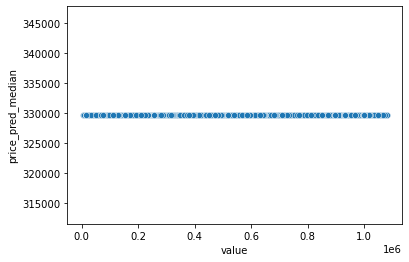

In [39]:
sns.scatterplot(x=y_train['value'], y=y_train['price_pred_median'])

In [40]:
# Linear regression, OLS

# Create the object
lm = LinearRegression(normalize=True)

# Fit the object
lm.fit(X_train_scaled, y_train.value)

# Use the object
y_train['price_pred_lm'] = lm.predict(X_train)
rmse_train = mean_squared_error(y_train.value, y_train.price_pred_lm) ** (1/2)

y_validate['price_pred_lm'] = lm.predict(X_validate)
rmse_validate = mean_squared_error(y_validate.value, y_validate.price_pred_lm) ** (1/2)

r2_train = explained_variance_score(y_train.value, y_train.price_pred_lm)
r2_validate = explained_variance_score(y_validate.value, y_validate.price_pred_lm)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,2),
      "\n",
      "\n",
      "R^2 using Mean\nTrain/In-Sample: ", round(r2_train, 2),
      "\nValidate/Out-of-Sample: ", round(r2_validate, 2))

RMSE for OLS using LinearRegression
Training/In-Sample:  422431406.35 
Validation/Out-of-Sample:  422616291.02 
 
 R^2 using Mean
Train/In-Sample:  -2321535.97 
Validate/Out-of-Sample:  -2335727.1


<AxesSubplot:xlabel='value', ylabel='price_pred_lm'>

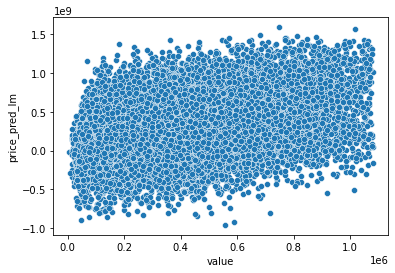

In [41]:
sns.scatterplot(x=y_train['value'], y=y_train['price_pred_lm'])

In [42]:
# Create the object
lars = LassoLars(alpha=1)

# Fit the model to train. 
# We must specify the column in y_train, 
# because we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.value)

# predict train
y_train['price_pred_lars'] = lars.predict(X_train)

# evaluate using rmse
rmse_train = mean_squared_error(y_train.value, y_train.price_pred_lars) ** (1/2)

# predict validate
y_validate['price_pred_lars'] = lars.predict(X_validate)
y_test['price_pred_lars'] = lars.predict(X_test)

# evaluate using rmse
rmse_validate = mean_squared_error(y_validate.value, y_validate.price_pred_lars) ** (1/2)

r2_train = explained_variance_score(y_train.value, y_train.price_pred_lars)
r2_validate = explained_variance_score(y_validate.value, y_validate.price_pred_lars)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,2),
      "\n",
      "\n",
      "R^2 using Mean\nTrain/In-Sample: ", round(r2_train, 2),
      "\nValidate/Out-of-Sample: ", round(r2_validate, 2))


RMSE for Lasso + Lars
Training/In-Sample:  209876.68 
Validation/Out-of-Sample:  208446.79 
 
 R^2 using Mean
Train/In-Sample:  0.21 
Validate/Out-of-Sample:  0.2


<AxesSubplot:xlabel='value', ylabel='price_pred_lars'>

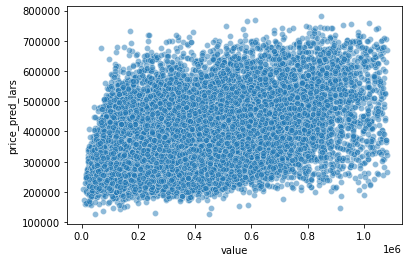

In [43]:
# visualize the coefficients
sns.scatterplot(x=y_train['value'], y=y_train['price_pred_lars'], alpha=0.5)



In [44]:
# Create the object
glm = TweedieRegressor(power=1, alpha=0)


# Fit the model to train. 
# We must specify the column in y_train, 
# becuase we  converted it to a dataframe from a series! 
glm.fit(X_train, y_train.value)

# predict train
y_train['price_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.value, y_train.price_pred_glm) ** (1/2)

# predict validate
y_validate['price_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.value, y_validate.price_pred_glm) ** (1/2)

r2_train = explained_variance_score(y_train.value, y_train.price_pred_glm)
r2_validate = explained_variance_score(y_validate.value, y_validate.price_pred_glm)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", round(rmse_train,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,2),
      "\n",
      "\n",
      "R^2 using Mean\nTrain/In-Sample: ", round(r2_train, 2),
      "\nValidate/Out-of-Sample: ", round(r2_validate, 2))

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  235731.54 
Validation/Out-of-Sample:  233594.88 
 
 R^2 using Mean
Train/In-Sample:  0.0 
Validate/Out-of-Sample:  0.0


/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:315: RuntimeWarning: invalid value encountered in add
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/prepr

<AxesSubplot:xlabel='value', ylabel='price_pred_glm'>

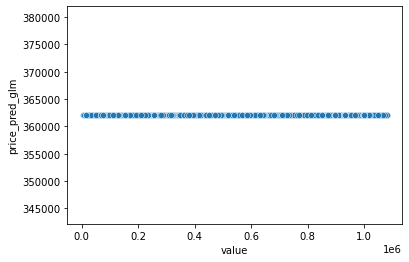

In [45]:
sns.scatterplot(x=y_train['value'], y=y_train['price_pred_glm'])

<AxesSubplot:xlabel='value', ylabel='price_pred_lars'>

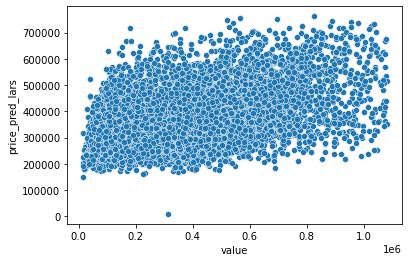

In [46]:
sns.scatterplot(x=y_test['value'], y=y_test['price_pred_lars'])

In [47]:
# predict test
y_test['price_pred_lars'] = lars.predict(X_test)

# evaluate using rmse
rmse_test = mean_squared_error(y_test.value, y_test.price_pred_lars) ** (1/2)

r2_test = explained_variance_score(y_test.value, y_test.price_pred_lars)

print("RMSE for Lasso + Lars\n",
      "Test/Out-of-Sample: ", round(rmse_test,2),
      "\n",
      "\n",
      "R^2 using Mean\n",
      "Test/Out-of-Sample: ", round(r2_test, 2))

RMSE for Lasso + Lars
 Test/Out-of-Sample:  208596.73 
 
 R^2 using Mean
 Test/Out-of-Sample:  0.21


<AxesSubplot:xlabel='value', ylabel='price_pred_lars'>

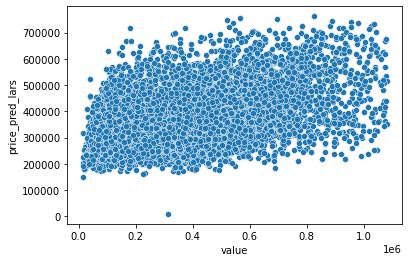

In [48]:
sns.scatterplot(x=y_test['value'], y=y_test['price_pred_lars'])

The three most predictive features for tax value are: area, bedroom, bathroom.

LassaLars was best model as determined by RMSE and R^2.

County had an effect on tax value, but was not one of the most important drivers.